<a href="https://colab.research.google.com/github/mahdaalma/ALMA-/blob/main/ARIMA_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA

In [1]:
!pip install PythonTsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from scipy.stats import boxcox,  boxcox_llf
from statsmodels.stats.diagnostic import het_arch

import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 5.5 MB/s eta 0:00:00


In [2]:
#Data IHSG dan Variabel Makroekonomi
IHSG=pd.read_csv('https://raw.githubusercontent.com/mahdaalma/ALMA-/refs/heads/main/data_ihsg_2007_2020.csv', sep=',')
IHSG.head(10)

,Date,Open,High,Low,Close,AdjClose,Volume,Inflasi,Kurs Jual,Kurs Beli,Kurs Tengah
0,1/31/2007,1813.45,1843.35,1627.76,1757.26,1757.19,501642800,6.26%,9111.818182,9021.181818,9066.500000
1,2/28/2007,1765.87,1824.99,1664.20,1740.97,1740.90,482985200,6.30%,9112.850000,9022.750000,9067.800000
2,3/31/2007,1752.11,1833.42,1692.22,1830.92,1830.85,445107500,6.52%,9209.952381,9117.952381,9163.952381
3,4/30/2007,1837.18,2021.01,1837.18,1999.17,1999.09,486833700,6.29%,9142.900000,9052.200000,9097.550000
4,5/31/2007,1995.17,2111.83,1987.89,2084.32,2084.24,550720100,6.01%,8888.476190,8800.190476,8844.333333
5,6/30/2007,2100.68,2167.45,2045.58,2139.28,2139.19,517207000,5.77%,9028.550000,8938.750000,8983.650000
6,7/31/2007,2140.62,2405.96,2140.62,2348.67,2348.58,376941900,6.06%,9112.363636,9021.909091,9067.136364
7,8/31/2007,2318.70,2322.80,1863.36,2194.34,2194.25,550133600,6.51%,9413.545455,9319.818182,9366.681818
8,9/30/2007,2194.43,2385.24,2192.79,2359.21,2359.11,891354100,6.95%,9356.500000,9263.300000,9309.900000
9,10/31/2007,2366.61,2689.92,2366.61,2643.49,2643.38,876734500,6.88%,9152.705882,9061.411765,9107.058824


In [3]:
#memeriksa tipe data
IHSG.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
AdjClose,float64
Volume,int64
Inflasi,object
Kurs Jual,float64
Kurs Beli,float64


In [4]:
#mengubah type data menjadi datetime
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%m/%d/%Y') # Changed the format string to '%m/%d/%Y'

In [5]:
#memeriksa tipe data
IHSG.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
AdjClose,float64
Volume,int64
Inflasi,object
Kurs Jual,float64
Kurs Beli,float64


In [6]:
#Hapus baris yang mengandung NaN
IHSG = IHSG.dropna()


# PREPROCESSING

In [7]:
# Sortir berdasarkan tanggal dan jadikan index
IHSG = IHSG.sort_values('Date')
IHSG.set_index('Date', inplace=True)

# Pilih kolom yang dibutuhkan
data = IHSG[['Close', 'Open']].dropna()

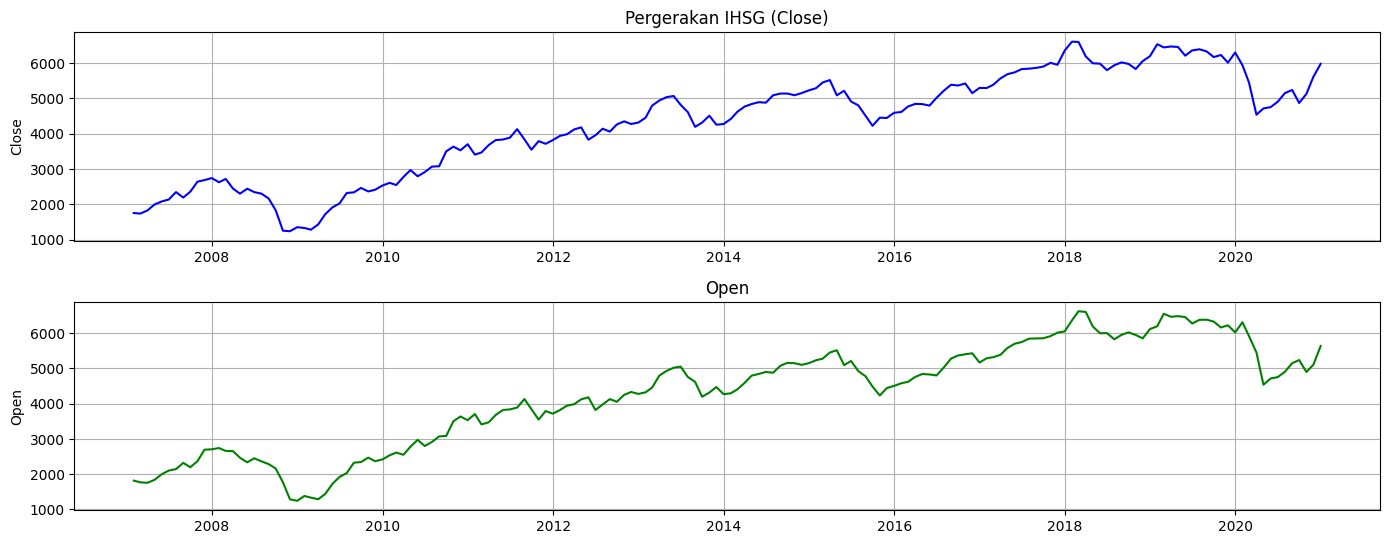

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot Close
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], color='blue')
plt.title('Pergerakan IHSG (Close)')
plt.ylabel('Close')
plt.grid(True)

# Plot Open
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Open'], color='green')
plt.title('Open')
plt.ylabel('Open')
plt.grid(True)


plt.tight_layout()
plt.show()

# SPLITING DATA TRAINING DAN TESTING

In [13]:
# Split di akhir 2022
train = data[:'2018']
test = data['2019':]

y_train = train['Close']
y_test = test['Close']
y_train_open = train['Open']
y_test_open= test['Open']

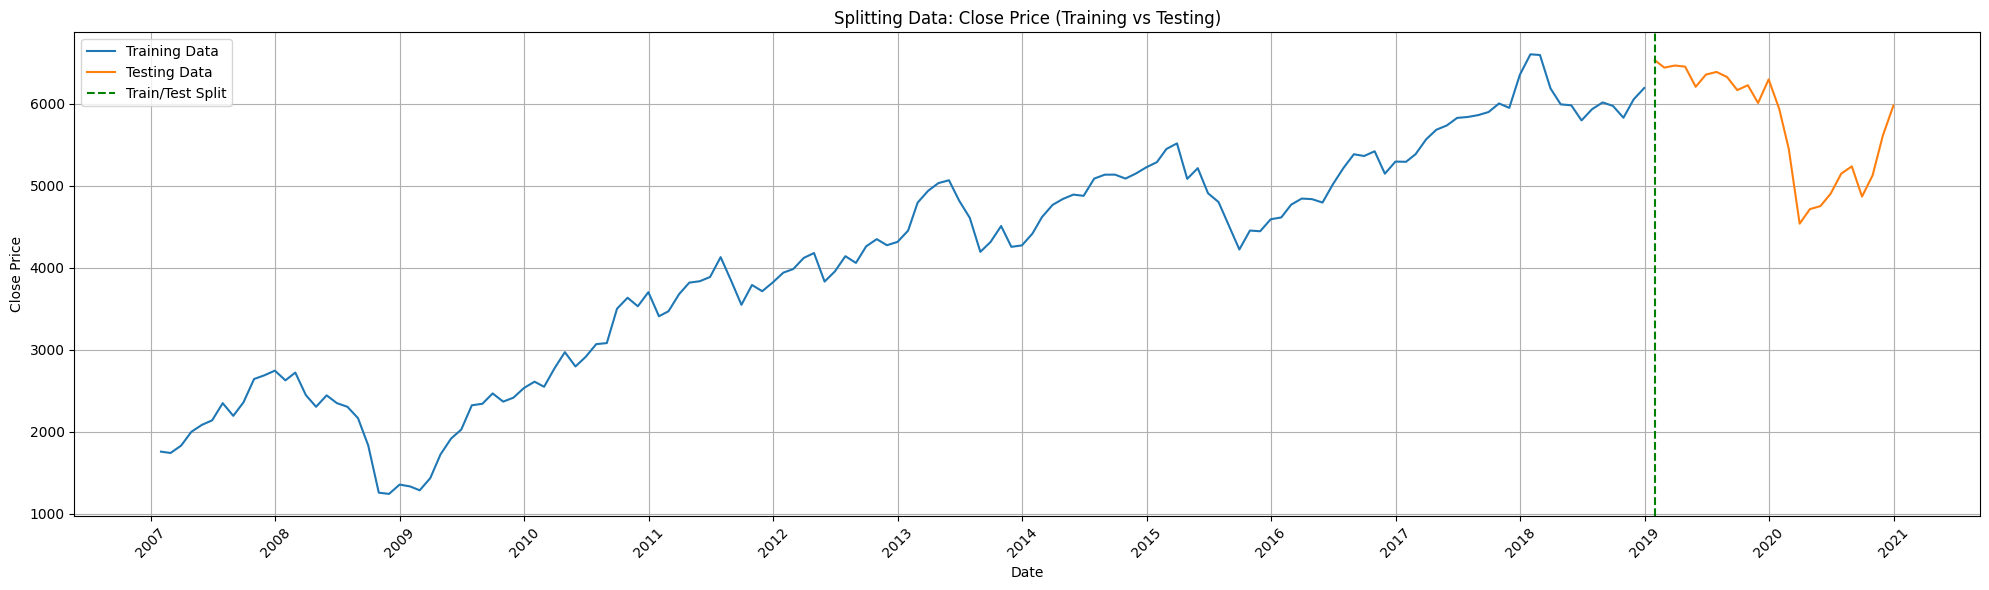

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Testing Data')
plt.axvline(x=y_test.index[0], color='green', linestyle='--', label='Train/Test Split')

# Format sumbu x agar menampilkan semua tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())     # Lokator tahunan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format jadi tahun saja
plt.xticks(rotation=45)  # Rotasi label agar tidak saling tumpang tindih

plt.title('Splitting Data: Close Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Supaya label tidak terpotong
plt.show()

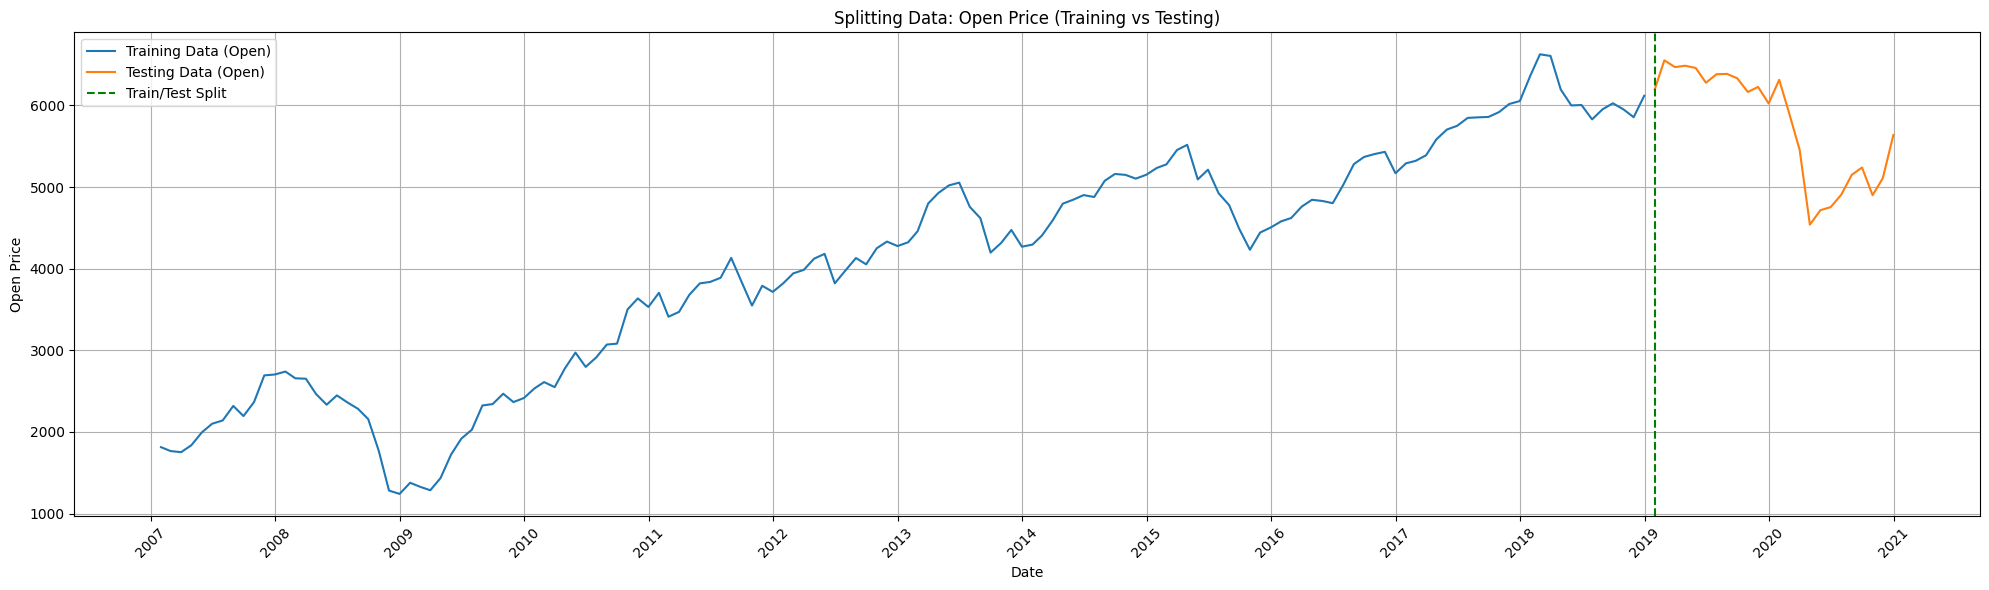

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(y_train_open.index, y_train_open, label='Training Data (Open)')
plt.plot(y_test_open.index, y_test_open, label='Testing Data (Open)')
plt.axvline(x=y_test_open.index[0], color='green', linestyle='--', label='Train/Test Split')

# Format sumbu x agar menampilkan semua tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title('Splitting Data: Open Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Display the first 10 rows of the training data
print("Training Data (first 10 rows):")
print(train.head(12))

# Display the first 10 rows of the testing data
print("\nTesting Data (first 10 rows):")
print(test.head(12))


Training Data (first 10 rows):
              Close     Open
Date                        
2007-01-31  1757.26  1813.45
2007-02-28  1740.97  1765.87
2007-03-31  1830.92  1752.11
2007-04-30  1999.17  1837.18
2007-05-31  2084.32  1995.17
2007-06-30  2139.28  2100.68
2007-07-31  2348.67  2140.62
2007-08-31  2194.34  2318.70
2007-09-30  2359.21  2194.43
2007-10-31  2643.49  2366.61
2007-11-30  2688.33  2692.51
2007-12-31  2745.83  2703.72

Testing Data (first 10 rows):
              Close     Open
Date                        
2019-01-31  6532.97  6197.87
2019-02-28  6443.35  6552.06
2019-03-31  6468.75  6468.62
2019-04-30  6455.35  6485.72
2019-05-31  6209.12  6458.12
2019-06-30  6358.63  6277.29
2019-07-31  6390.50  6381.18
2019-08-31  6328.47  6385.26
2019-09-30  6169.10  6331.15
2019-10-31  6228.32  6163.98
2019-11-30  6011.83  6225.81
2019-12-31  6299.54  6023.61


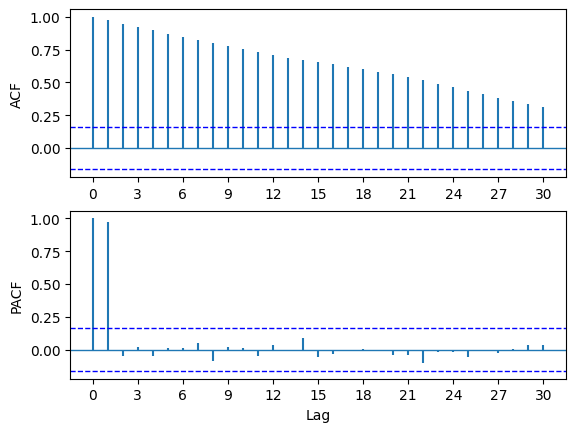

In [17]:
#Plot acf dan pacf data train close
acf_pacf_fig(y_train, both=True, lag=30); plt.show()


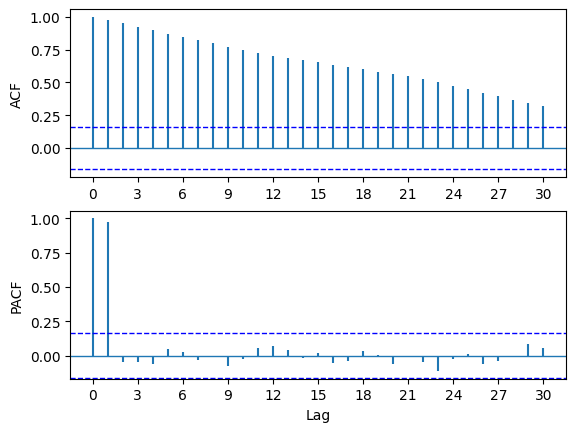

In [18]:
#Plot acf dan pacf data train open
acf_pacf_fig(y_train_open, both=True, lag=30); plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller

# === ADF untuk data Close ===
print("=== ADF Test - Data Train Close ===")
result_close = adfuller(y_train, autolag='AIC')
print("ADF Statistic:", result_close[0])
print("p-value:", result_close[1])
print("Critical Values:")
for key, value in result_close[4].items():
    print(f"   {key}: {value}")
print("Kesimpulan:", "Stasioner" if result_close[1] < 0.05 else "Tidak Stasioner")
print()

# === ADF untuk data Open ===
print("=== ADF Test - Data Train Open ===")
result_open = adfuller(y_train_open, autolag='AIC')
print("ADF Statistic:", result_open[0])
print("p-value:", result_open[1])
print("Critical Values:")
for key, value in result_open[4].items():
    print(f"   {key}: {value}")
print("Kesimpulan:", "Stasioner" if result_open[1] < 0.05 else "Tidak Stasioner")

=== ADF Test - Data Train Close ===
ADF Statistic: -0.9914339254539629
p-value: 0.7563757440215184
Critical Values:
   1%: -3.477261624048995
   5%: -2.8821181874544233
   10%: -2.5777431104939494
Kesimpulan: Tidak Stasioner

=== ADF Test - Data Train Open ===
ADF Statistic: -0.8173583914598205
p-value: 0.8139699207192643
Critical Values:
   1%: -3.4782936965183815
   5%: -2.882567574015525
   10%: -2.5779830117488745
Kesimpulan: Tidak Stasioner


# STASIONERITAS

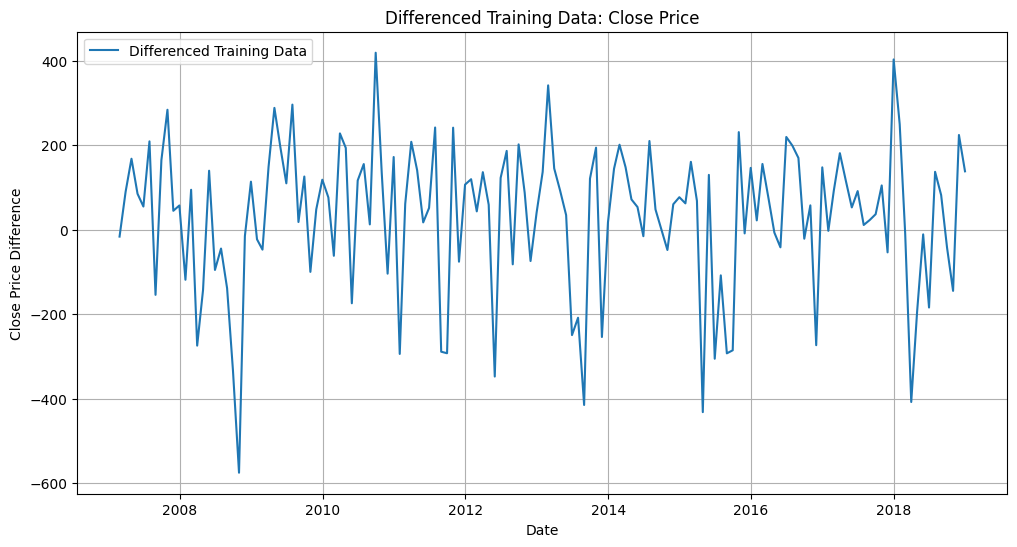

p-value (differenced data): 5.91306108067213e-18


In [20]:
# prompt: lakukan differencing data y_train

import matplotlib.pyplot as plt
# Calculate the difference of the y_train series
y_train_diff = y_train.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff.index, y_train_diff, label='Differenced Training Data')
plt.title('Differenced Training Data: Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price Difference')
plt.legend()
plt.grid(True)
plt.show()

# Perform ADF test on the differenced data
result_diff = adfuller(y_train_diff, autolag='AIC')
p_value_diff = float(result_diff[1])
print("p-value (differenced data):", p_value_diff)


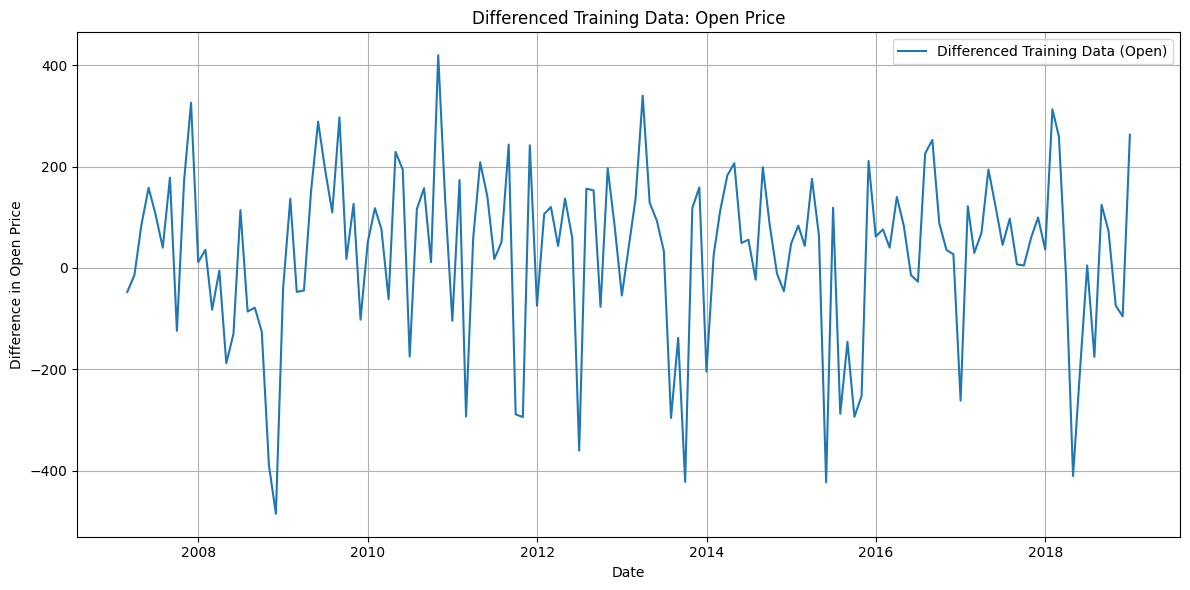

=== ADF Test - Data Train Open (After Differencing) ===
ADF Statistic: -5.919369571394666
p-value: 2.527803414374903e-07
Kesimpulan: Stasioner


In [21]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# === 1. Differencing pada data Open ===
y_train_open_diff = y_train_open.diff().dropna()

# === 2. Plot data setelah differencing ===
plt.figure(figsize=(12, 6))
plt.plot(y_train_open_diff.index, y_train_open_diff, label='Differenced Training Data (Open)')
plt.title('Differenced Training Data: Open Price')
plt.xlabel('Date')
plt.ylabel('Difference in Open Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. ADF Test pada data hasil differencing ===
print("=== ADF Test - Data Train Open (After Differencing) ===")
result_diff_open = adfuller(y_train_open_diff, autolag='AIC')
print("ADF Statistic:", result_diff_open[0])
print("p-value:", result_diff_open[1])
print("Kesimpulan:", "Stasioner" if result_diff_open[1] < 0.05 else "Tidak Stasioner")

Plot hasil differencing menunjukkan bahwa data sudah stasioner terhadap nilai tengah. Selanjutnya, dilakukan pengecekan lebih lanjut menggunakan plot ACF dan uji ADF.

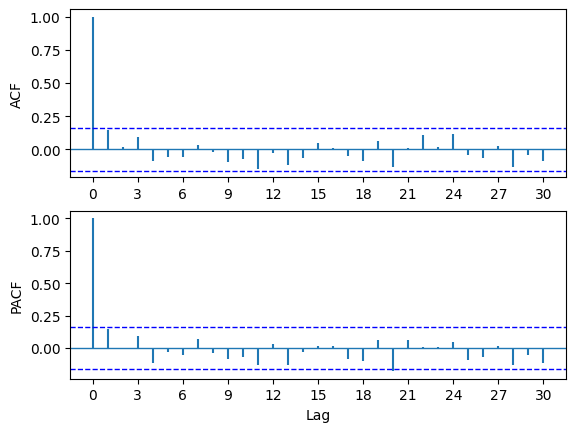

=== ADF TEST (Open - Differenced) ===
ADF Statistic: -10.202700252887418
p-value: 5.91306108067213e-18
Kesimpulan: Stasioner


In [28]:
# prompt: PLOT ACF PACF DAN UJI ADF

import matplotlib.pyplot as plt
#Plot acf dan pacf data train
acf_pacf_fig(y_train_diff, both=True, lag=30); plt.show()
# === Uji ADF pada data Open setelah differencing ===
result_open_diff = adfuller(y_train_diff, autolag='AIC')
print("=== ADF TEST (Open - Differenced) ===")
print("ADF Statistic:", result_open_diff[0])
print("p-value:", result_open_diff[1])
print("Kesimpulan:", "Stasioner" if result_open_diff[1] < 0.05 else "Tidak Stasioner")


In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Uji Ljung-Box untuk autokorelasi residual
ljung_box_test = acorr_ljungbox(y_train_diff, lags=range(1, 20), return_df=True)

print("Ljung-Box Test p-value:")
print(ljung_box_test)

Ljung-Box Test p-value:
      lb_stat  lb_pvalue
1    3.096389   0.078466
2    3.165932   0.205365
3    4.439398   0.217760
4    5.519932   0.237983
5    6.018321   0.304440
6    6.536251   0.365868
7    6.707780   0.459926
8    6.778454   0.560714
9    8.089549   0.525148
10   8.841892   0.547172
11  12.408976   0.333700
12  12.506321   0.405919
13  14.671074   0.328334
14  15.329418   0.356013
15  15.766264   0.397754
16  15.798766   0.467092
17  16.166613   0.512056
18  17.326258   0.500792
19  18.012559   0.521599


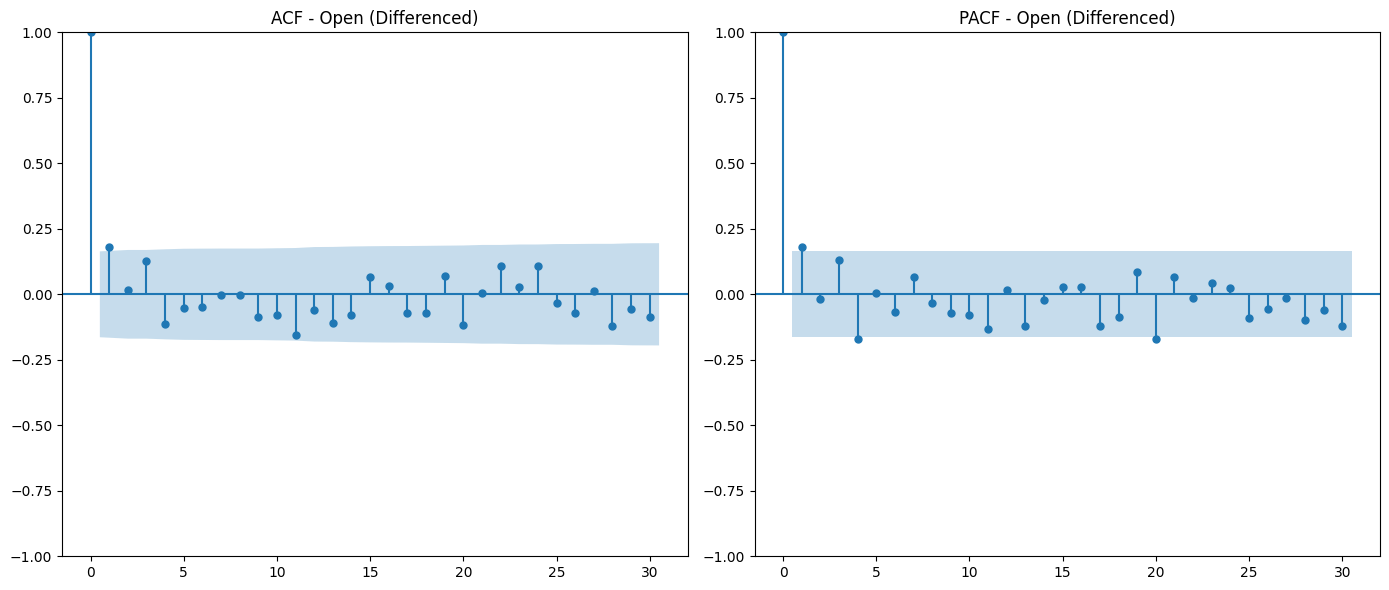

=== ADF TEST (Open - Differenced) ===
ADF Statistic: -5.919369571394666
p-value: 2.527803414374903e-07
Kesimpulan: Stasioner


In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Differencing data Open ===
y_train_open_diff = y_train_open.diff().dropna()

# === Plot ACF dan PACF untuk data differenced Open ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y_train_open_diff, ax=plt.gca(), lags=30)
plt.title('ACF - Open (Differenced)')

plt.subplot(1, 2, 2)
plot_pacf(y_train_open_diff, ax=plt.gca(), lags=30, method='ywm')
plt.title('PACF - Open (Differenced)')

plt.tight_layout()
plt.show()

# === Uji ADF pada data Open setelah differencing ===
result_open_diff = adfuller(y_train_open_diff, autolag='AIC')
print("=== ADF TEST (Open - Differenced) ===")
print("ADF Statistic:", result_open_diff[0])
print("p-value:", result_open_diff[1])
print("Kesimpulan:", "Stasioner" if result_open_diff[1] < 0.05 else "Tidak Stasioner")

Berdasarkan plot ACF yang menunjukkan pola cut-off pada lag 1, dapat disimpulkan bahwa data sudah stasioner terhadap nilai tengah. Nilai ADF < 0.05 sehingga data stasioner terhadap nilai tengah

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Uji Ljung-Box untuk autokorelasi residual
ljung_box_test = acorr_ljungbox(y_train_open_diff, lags=range(1, 20), return_df=True)

print("Ljung-Box Test p-value:")
print(ljung_box_test)

Ljung-Box Test p-value:
      lb_stat  lb_pvalue
1    4.851664   0.027619
2    4.894811   0.086518
3    7.306670   0.062740
4    9.247397   0.055205
5    9.685310   0.084659
6   10.030349   0.123380
7   10.030612   0.186845
8   10.033475   0.262684
9   11.149482   0.265602
10  12.107360   0.277936
11  15.904755   0.144704
12  16.449329   0.171512
13  18.304780   0.146286
14  19.324245   0.152926
15  19.994499   0.172144
16  20.162872   0.212974
17  20.957398   0.228202
18  21.814853   0.240309
19  22.602106   0.255322


Lambda Box-Cox (setelah differencing): 1.54830827679503


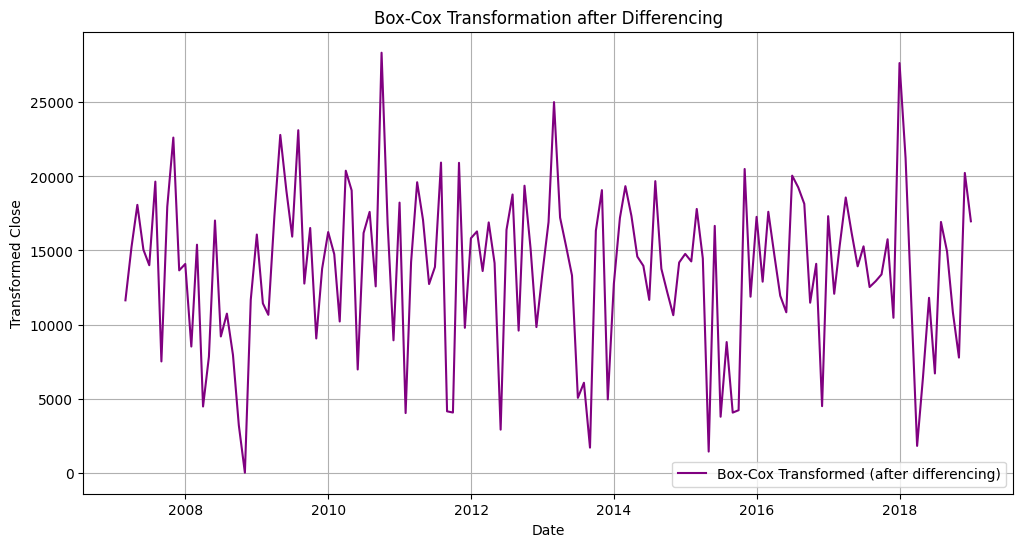

In [27]:
from scipy.stats import boxcox, boxcox_normmax
import matplotlib.pyplot as plt

# Geser data differenced agar semua nilai > 0
y_diff_shifted = y_train_diff + abs(min(y_train_diff)) + 1

# Estimasi lambda terbaik
lambda_boxcox_diff = boxcox_normmax(y_diff_shifted, method='mle')
print("Lambda Box-Cox (setelah differencing):", lambda_boxcox_diff)

# Transformasi Box-Cox
y_diff_boxcox = boxcox(y_diff_shifted, lmbda=lambda_boxcox_diff)

# Plot hasil transformasi Box-Cox
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff.index, y_diff_boxcox, label='Box-Cox Transformed (after differencing)', color='purple')
plt.title('Box-Cox Transformation after Differencing')
plt.xlabel('Date')
plt.ylabel('Transformed Close')
plt.legend()
plt.grid(True)
plt.show()

Lambda Box-Cox (Open - setelah differencing): 1.4229289754091


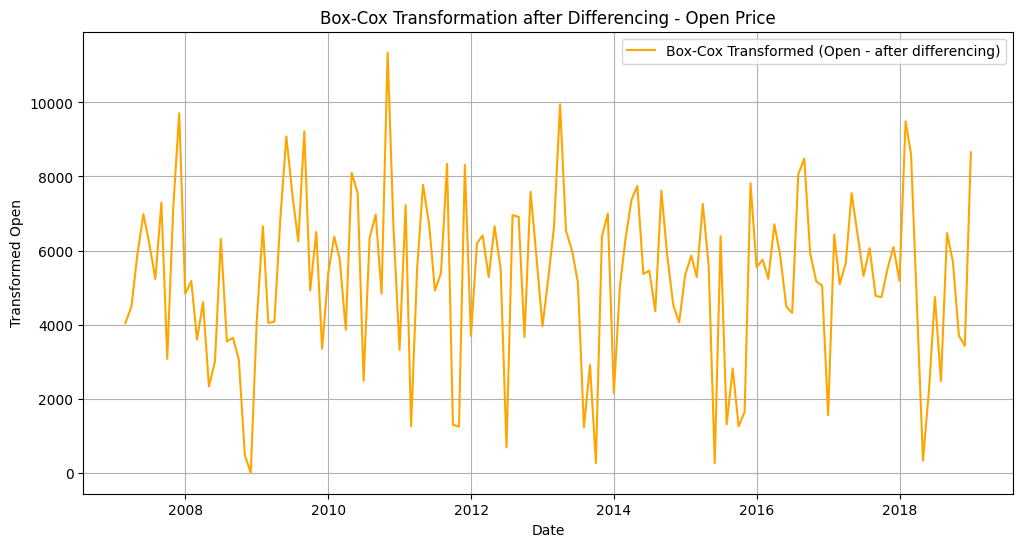

In [29]:
from scipy.stats import boxcox, boxcox_normmax
import matplotlib.pyplot as plt

# Lakukan differencing data Open
y_train_open_diff = y_train_open.diff().dropna()

# Geser data agar semua nilai > 0 sebelum transformasi Box-Cox
y_open_diff_shifted = y_train_open_diff + abs(min(y_train_open_diff)) + 1

# Estimasi nilai lambda terbaik untuk Box-Cox
lambda_boxcox_open = boxcox_normmax(y_open_diff_shifted, method='mle')
print("Lambda Box-Cox (Open - setelah differencing):", lambda_boxcox_open)

# Transformasi Box-Cox pada data yang sudah di-shift
y_open_boxcox = boxcox(y_open_diff_shifted, lmbda=lambda_boxcox_open)

# Plot hasil transformasi Box-Cox
plt.figure(figsize=(12, 6))
plt.plot(y_train_open_diff.index, y_open_boxcox, label='Box-Cox Transformed (Open - after differencing)', color='orange')
plt.title('Box-Cox Transformation after Differencing - Open Price')
plt.xlabel('Date')
plt.ylabel('Transformed Open')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from statsmodels.stats.diagnostic import het_arch

# Uji ARCH pada data Close
arch_test_close = het_arch(y_train_diff)
stat_close = arch_test_close[0]
pval_close = arch_test_close[1]

print("=== Uji ARCH - Close ===")
print(f"Statistik ARCH: {stat_close}")
print(f"p-value: {pval_close}")
if pval_close < 0.05:
    print("Terdapat gejala heteroskedastisitas pada Close.\n")
else:
    print("Tidak terdapat gejala heteroskedastisitas pada Close.\n")

# Uji ARCH pada data Open
y_train_open_diff = y_train_open.diff().dropna()
arch_test_open = het_arch(y_train_open_diff)
stat_open = arch_test_open[0]
pval_open = arch_test_open[1]

print("=== Uji ARCH - Open ===")
print(f"Statistik ARCH: {stat_open}")
print(f"p-value: {pval_open}")
if pval_open < 0.05:
    print("Terdapat gejala heteroskedastisitas pada Open.")
else:
    print("Tidak terdapat gejala heteroskedastisitas pada Open.")

=== Uji ARCH - Close ===
Statistik ARCH: 7.160150740297598
p-value: 0.7102441917700117
Tidak terdapat gejala heteroskedastisitas pada Close.

=== Uji ARCH - Open ===
Statistik ARCH: 8.541967157871447
p-value: 0.5760520321242687
Tidak terdapat gejala heteroskedastisitas pada Open.



Untuk mengecek kestasioneran terhadap ragam, dilakukan analisis terhadap nilai lambda menggunakan transformasi Box-Cox. Sebelum transformasi dilakukan, ditambahkan konstanta pada data karena metode Box-Cox tidak dapat diterapkan pada data yang mengandung nilai nol atau negatif. Hasil transformasi menunjukkan bahwa nilai lambda sebesar 1, yang mengindikasikan bahwa data telah stasioner terhadap ragam. Hal ini diperkuat oleh hasil uji ARCH, di mana p-value yang diperoleh lebih besar dari 0.05, sehingga tidak terdapat indikasi adanya gejala heteroskedastisitas.”


# ARIMA

## IDENTIFIKASI MODEL TERBAIK

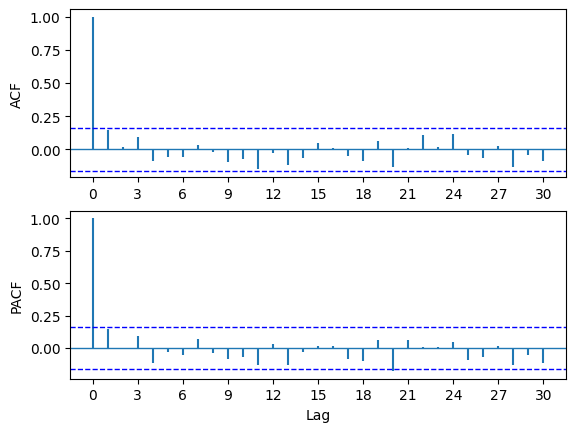

In [33]:
# prompt: plot acf dan pacf hasil differencing CLOSE

import matplotlib.pyplot as plt
# Plot ACF and PACF of the differenced data
acf_pacf_fig(y_train_diff, both=True, lag=30); plt.show()


Plot ACF yang TIDAK menunjukkan cut-off pada komponen MA(1) dan AR(1).
Dari hasil tersebut, maka model tentatif yang dapat di uji adalah ARIMA (0,1,0)

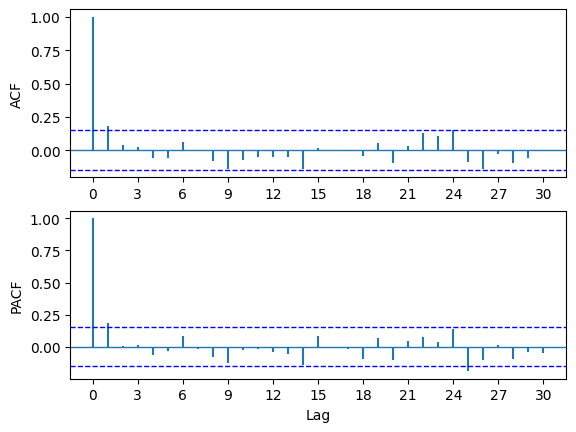

In [ ]:
# prompt: plot acf dan pacf hasil differencing OPEN

import matplotlib.pyplot as plt
# Plot ACF and PACF of the differenced data
acf_pacf_fig(y_train_open_diff, both=True, lag=30); plt.show()

Plot ACF yang menunjukkan cut-off di lag 1 mengindikasikan adanya komponen MA(1). Sementara itu, plot PACF yang mengalami cut-off di lag 1 AR(1).
Dari hasil tersebut, maka model tentatif yang dapat di uji adalah data open
*   ARIMA (0,1,1)
*   ARIMA (1,1,0)

## ARIMA (0,1,0)

In [34]:
#MODEL RANDOM WALK CLOSE
model_rw = ARIMA(y_train_diff, order=(0,0,0)).fit()
print(model_rw.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  143
Model:                          ARIMA   Log Likelihood                -940.979
Date:                Sun, 04 May 2025   AIC                           1885.958
Time:                        08:04:06   BIC                           1891.884
Sample:                    02-28-2007   HQIC                          1888.366
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0296     16.960      1.830      0.067      -2.211      64.270
sigma2      3.042e+04   3545.705      8.578      0.000    2.35e+04    3.74e+04
Ljung-Box (L1) (Q):                   3.10   Jarque-

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


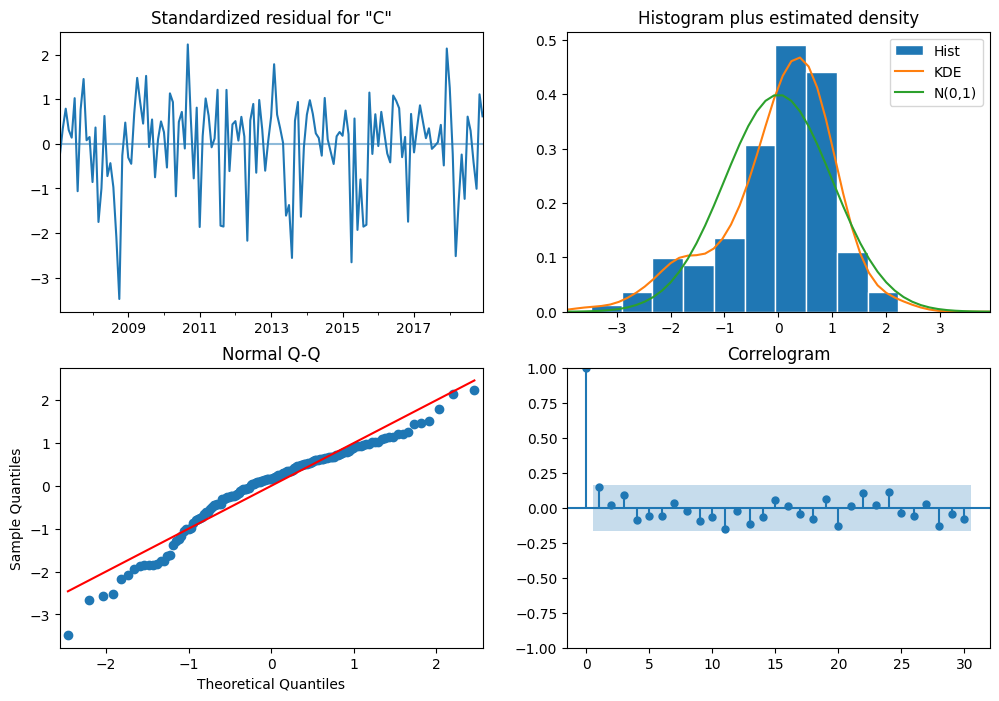


=== UJI STATISTIK RESIDUAL RW CLOSE) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.7654678585249821
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 31.137520245031848 p-value: 0.408668914931901
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9462959242595577 p-value: 2.5475155312531078e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 20.94000694615362 p-value: 2.8374960532839803e-05


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_rw.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL RW CLOSE) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_rw.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_rw.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_rw.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_rw.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

## ARIMA (0,1,1)

In [35]:
#MODEL MA(1) CLOSE
model_ma1 = ARIMA(y_train_diff, order=(0,0,1)).fit()
print(model_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  143
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -939.441
Date:                Sun, 04 May 2025   AIC                           1884.882
Time:                        08:06:01   BIC                           1893.770
Sample:                    02-28-2007   HQIC                          1888.494
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0383     19.013      1.632      0.103      -6.227      68.304
ma.L1          0.1487      0.082      1.817      0.069      -0.012       0.309
sigma2      2.976e+04   3551.565      8.380      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [36]:
#MODEL MA(1) OPEN
model_ma1open = ARIMA(y_train_open_diff, order=(0,0,1)).fit()
print(model_ma1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  143
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -933.958
Date:                Sun, 04 May 2025   AIC                           1873.916
Time:                        08:06:06   BIC                           1882.804
Sample:                    02-28-2007   HQIC                          1877.528
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.1955     18.878      1.599      0.110      -6.805      67.197
ma.L1          0.2044      0.080      2.565      0.010       0.048       0.361
sigma2      2.756e+04   3279.963      8.402      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


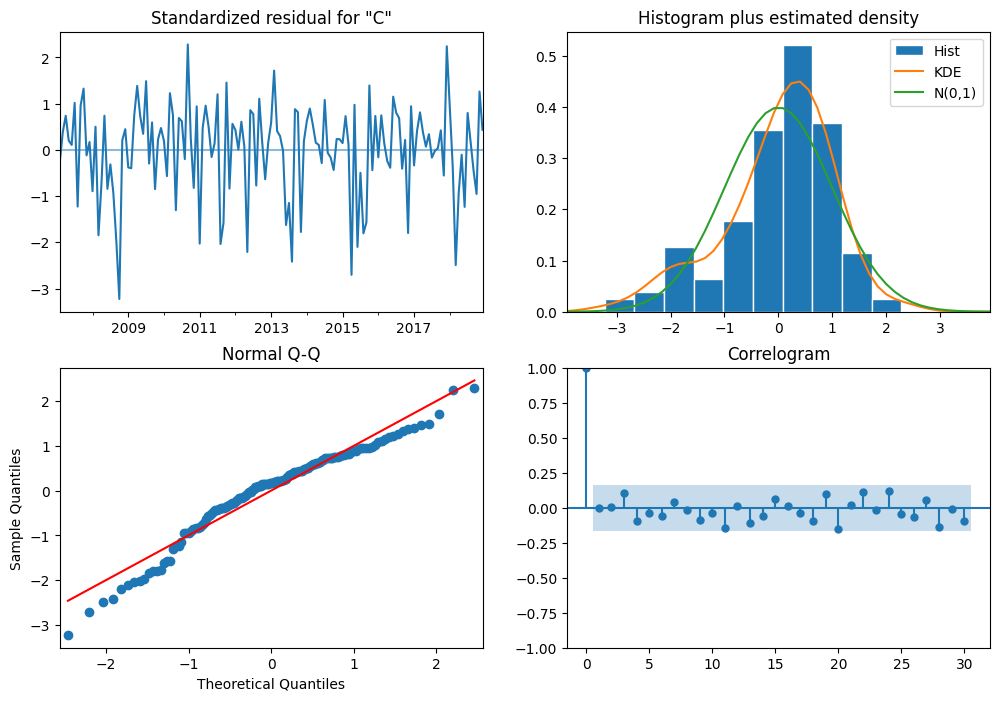


=== UJI STATISTIK RESIDUAL (MA1) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.7620064939721557
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 30.368509897183944 p-value: 0.4469013853062492
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9543469382449148 p-value: 0.00011483030310316745
Uji Normalitas (Jarque-Bera) - JB Statistic: 15.708136396594343 p-value: 0.00038816960083378854


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL MA CLOSE===
model_ma1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (MA1) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ma1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ma1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ma1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ma1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)


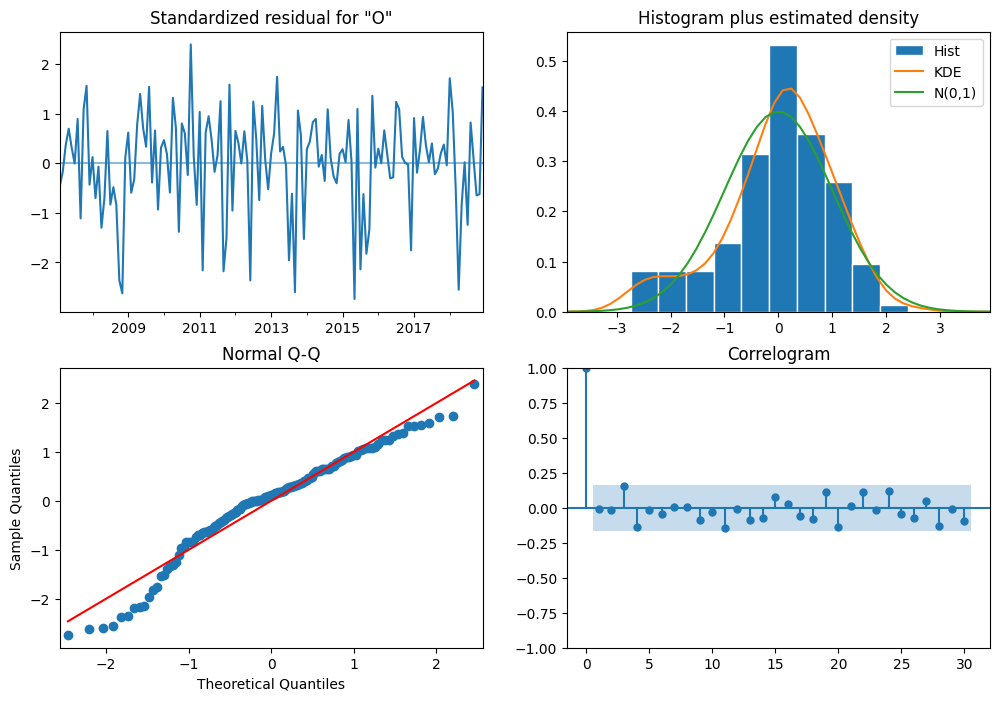


=== UJI STATISTIK RESIDUAL (MA(1) OPEN) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.6392229927509487
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 32.94858831090862 p-value: 0.32477764161104955
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9581587279436258 p-value: 0.000244444558761439
Uji Normalitas (Jarque-Bera) - JB Statistic: 13.018255475810108 p-value: 0.0014897786339139454


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ma1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (MA(1) OPEN) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ma1open.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ma1open.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ma1open.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ma1open.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

## ARIMA (1,1,0)

In [40]:
#MODEL AR(1)
model_ar1 = ARIMA(y_train_diff, order=(1,0,0)).fit()
print(model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  143
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -939.454
Date:                Sun, 04 May 2025   AIC                           1884.908
Time:                        08:08:13   BIC                           1893.796
Sample:                    02-28-2007   HQIC                          1888.520
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0297     19.539      1.588      0.112      -7.266      69.325
ar.L1          0.1450      0.081      1.793      0.073      -0.014       0.304
sigma2      2.996e+04   3627.852      8.259      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


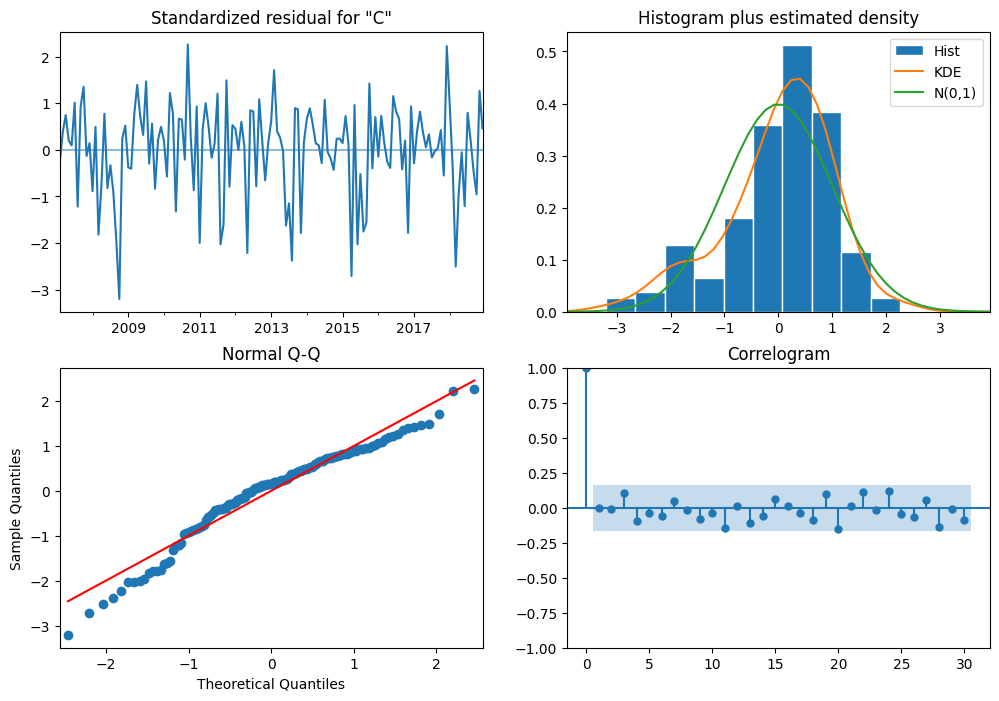


=== UJI STATISTIK RESIDUAL (AR1) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.7635900368050206
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 29.76862190649548 p-value: 0.4775485737448417
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9560760138232732 p-value: 0.00016118751378134188
Uji Normalitas (Jarque-Bera) - JB Statistic: 15.124717184511466 p-value: 0.000519648159233612


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ar1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (AR1) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ar1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ar1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ar1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)


In [42]:
#MODEL AR(1) OPEN
model_ar1open = ARIMA(y_train_open_diff, order=(1,0,0)).fit()
print(model_ar1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  143
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -934.127
Date:                Sun, 04 May 2025   AIC                           1874.255
Time:                        08:08:22   BIC                           1883.143
Sample:                    02-28-2007   HQIC                          1877.867
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.1858     19.319      1.562      0.118      -7.679      68.051
ar.L1          0.1837      0.079      2.331      0.020       0.029       0.338
sigma2      2.763e+04   3310.916      8.344      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


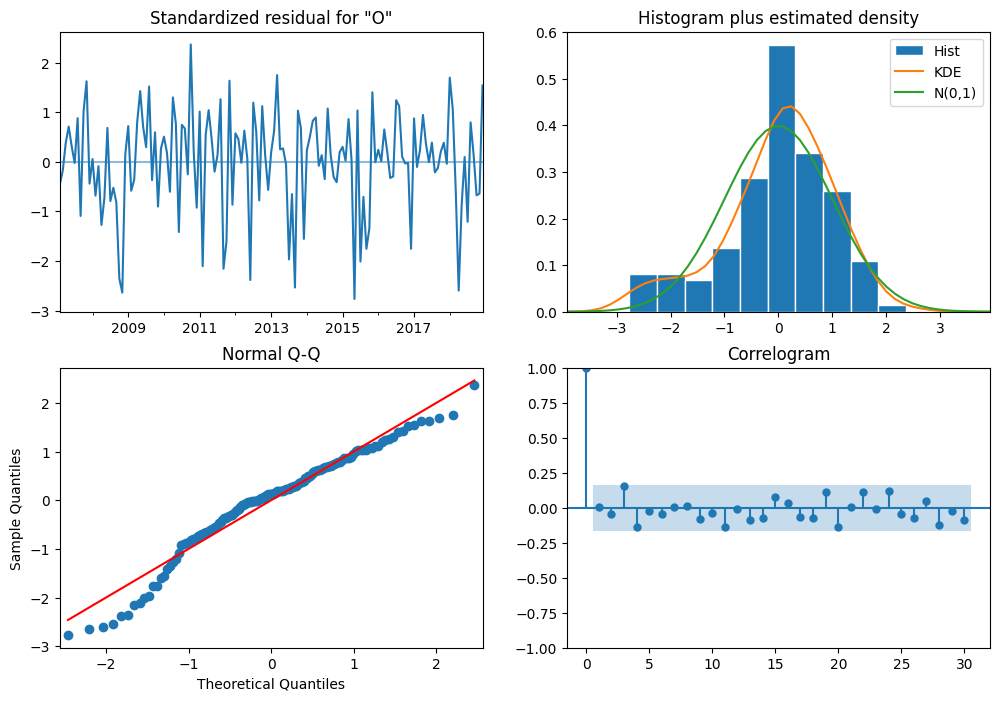


=== UJI STATISTIK RESIDUAL (AR1)OPEN ===
Uji Autokorelasi (ARCH Test) - p-value: 0.7635900368050206
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 29.76862190649548 p-value: 0.4775485737448417
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9560760138232732 p-value: 0.00016118751378134188
Uji Normalitas (Jarque-Bera) - JB Statistic: 15.124717184511466 p-value: 0.000519648159233612


In [43]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ar1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (AR1)OPEN ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ar1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ar1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ar1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

Kesimpulan Model (0,1,0) (0,1,1) dan (1,1,0)

Memenuhi Asumsi:

	* Homoskedastisitas → Varians residual konstan (p-value > 0.05) tidak ada heteroskedastisitas.
	* Tidak ada autokorelasi signifikan → p-value > 0.05, sehingga gagal menolak H₀, yang berarti residual bersifat white noise.
	* Residual acak → p-value > 0.05, sehingga residual dianggap acak tanpa pola sistematis.

Tidak Memenuhi Asumsi:

	* Normalitas residual tidak terpenuhi → Uji Shapiro-Wilk dan Jarque-Bera menunjukkan p-value < 0.05, sehingga H₀ ditolak dan residual tidak berdistribusi normal.
	* Namun, karena jumlah data besar, berdasarkan Dalil Limit Pusat, asumsi normalitas dapat diabaikan.

Kesimpulannya Model (0,1,1) dan (1,1,0) dapat digunakan untuk baselin analisis time series.

In [44]:
import pandas as pd

# Create a DataFrame to store AIC and BIC values
results_df = pd.DataFrame(columns=['Model', 'AIC', 'BIC'])

# Append RW model results
results_df = pd.concat([results_df, pd.DataFrame([{'Model': '(0,1,0)', 'AIC': model_rw.aic, 'BIC': model_rw.bic}])], ignore_index=True)

# Append MA(1) model results for Open data
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1) Open', 'AIC': model_ma1open.aic, 'BIC': model_ma1open.bic}])], ignore_index=True)

# Append AR(1) model results for Open data
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'AR(1) Open', 'AIC': model_ar1open.aic, 'BIC': model_ar1open.bic}])], ignore_index=True)

# Display the DataFrame
print(results_df)

        Model          AIC          BIC
0     (0,1,0)  1885.958281  1891.883971
1       MA(1)  1884.881833  1893.770367
2       AR(1)  1884.907939  1893.796473
3  MA(1) Open  1873.915845  1882.804379
4  AR(1) Open  1874.254632  1883.143166


<ipython-input-44-c723d3d26007>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Model': '(0,1,0)', 'AIC': model_rw.aic, 'BIC': model_rw.bic}])], ignore_index=True)


Berdasarkan nilai AIC dan BIC  dari pemilihan model tentatif, model terbaik adalah Model MA(1) untuk data CLOSE dan OPEN

#OVERFITTING MODEL ARIMA
Model yang dilakukan overfitting ARIMA (0,1,0) data CLOSE dan ARIMA (0,1,1) OPEN

DATA OPEN
*   ARIMAX (1,1,1)
*   ARIMAX (2,1,1)

DATA CLOSE
*   ARIMAX (0,1,1)
*   ARIMAX (0,1,0)
*   ARIMAX (1,1,1)
*   ARIMAX (2,1,1)


In [45]:
#MODEL ARIMA(1,1,1)
model_arima1 = ARIMA(y_train_diff, order=(1,0,1)).fit()
print(model_arima1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  143
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -939.449
Date:                Sun, 04 May 2025   AIC                           1886.898
Time:                        08:15:05   BIC                           1898.749
Sample:                    02-28-2007   HQIC                          1891.714
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0697     19.795      1.570      0.117      -7.727      69.866
ar.L1          0.2587      0.538      0.481      0.631      -0.796       1.313
ma.L1         -0.1169      0.559     -0.209      0.8

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [46]:
#MODEL ARIMA(1,1,1) OPEN
model_arima1open = ARIMA(y_train_open_diff, order=(1,0,1)).fit()
print(model_arima1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  143
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -932.315
Date:                Sun, 04 May 2025   AIC                           1872.630
Time:                        08:15:08   BIC                           1884.481
Sample:                    02-28-2007   HQIC                          1877.445
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2174     17.942      1.684      0.092      -4.948      65.383
ar.L1         -0.5483      0.209     -2.618      0.009      -0.959      -0.138
ma.L1          0.7575      0.169      4.476      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [47]:
#MODEL ARIMA(2,1,1)
model_arima21 = ARIMA(y_train_diff, order=(2,0,1)).fit()
print(model_arima21.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -938.806
Date:                Sun, 04 May 2025   AIC                           1887.612
Time:                        08:15:12   BIC                           1902.427
Sample:                    02-28-2007   HQIC                          1893.632
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0077     19.206      1.615      0.106      -6.635      68.650
ar.L1         -0.6177      0.407     -1.517      0.129      -1.416       0.181
ar.L2          0.0515      0.123      0.421      0.6

In [48]:
#MODEL ARIMA(2,1,1) OPEN
model_arima21open = ARIMA(y_train_open_diff, order=(2,0,1)).fit()
print(model_arima21open.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  143
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -932.238
Date:                Sun, 04 May 2025   AIC                           1874.475
Time:                        08:15:15   BIC                           1889.290
Sample:                    02-28-2007   HQIC                          1880.495
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2212     18.896      1.599      0.110      -6.815      67.257
ar.L1         -0.5634      0.236     -2.384      0.017      -1.027      -0.100
ar.L2          0.0390      0.110      0.353      0.7

## UJI DIAGNOSTIK MODEL

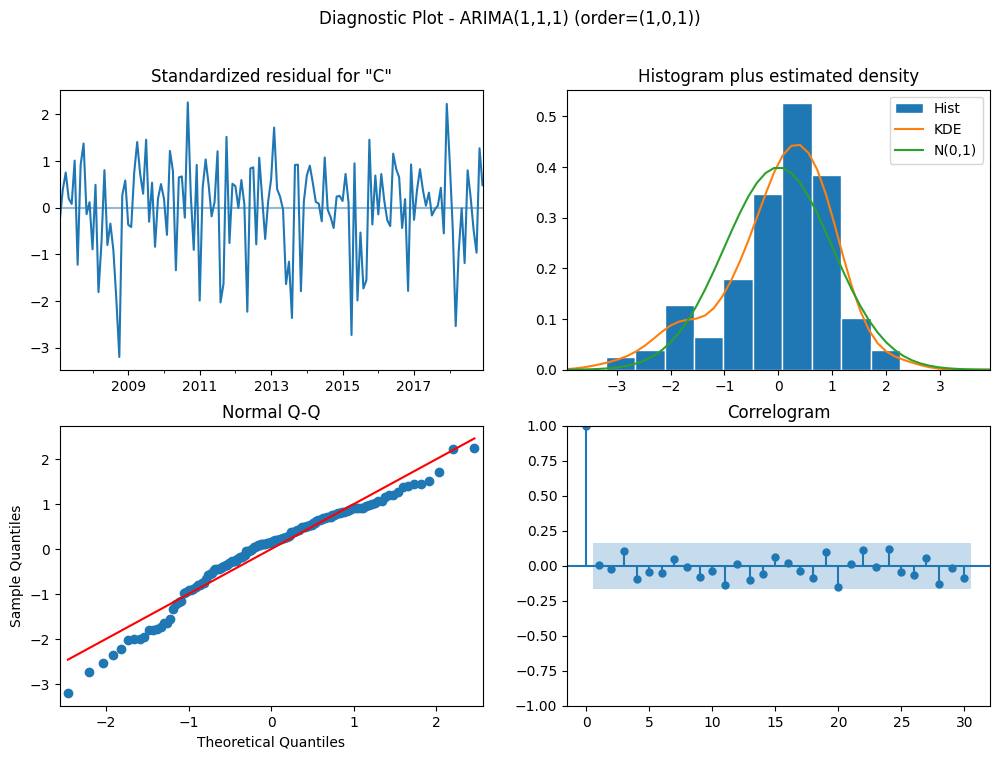

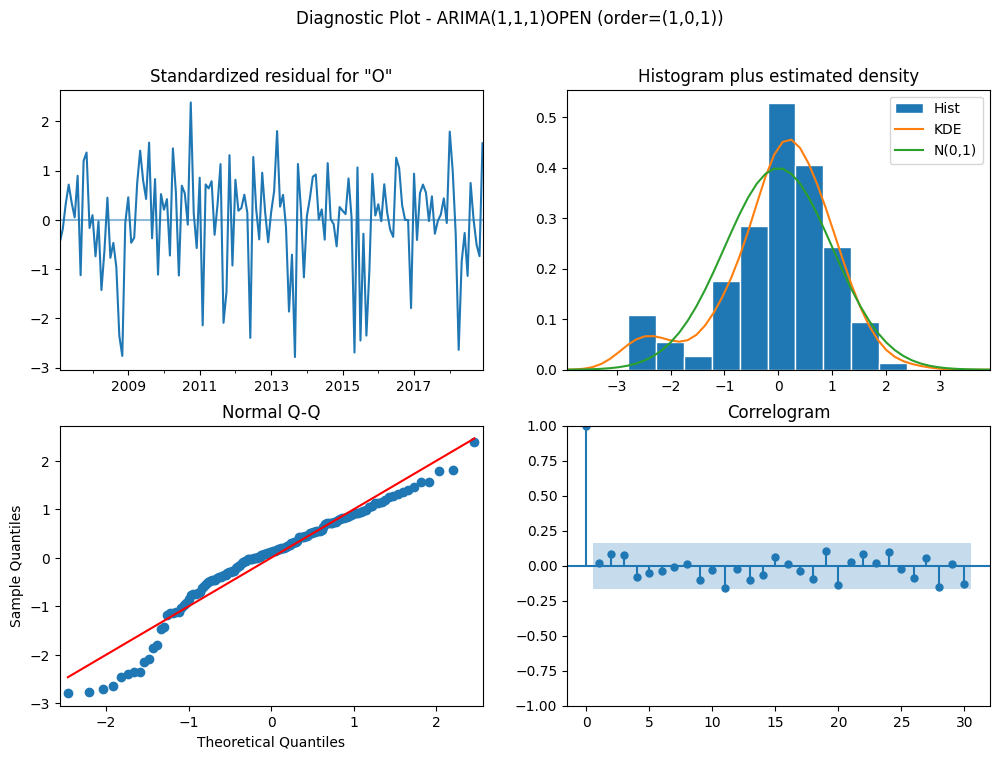

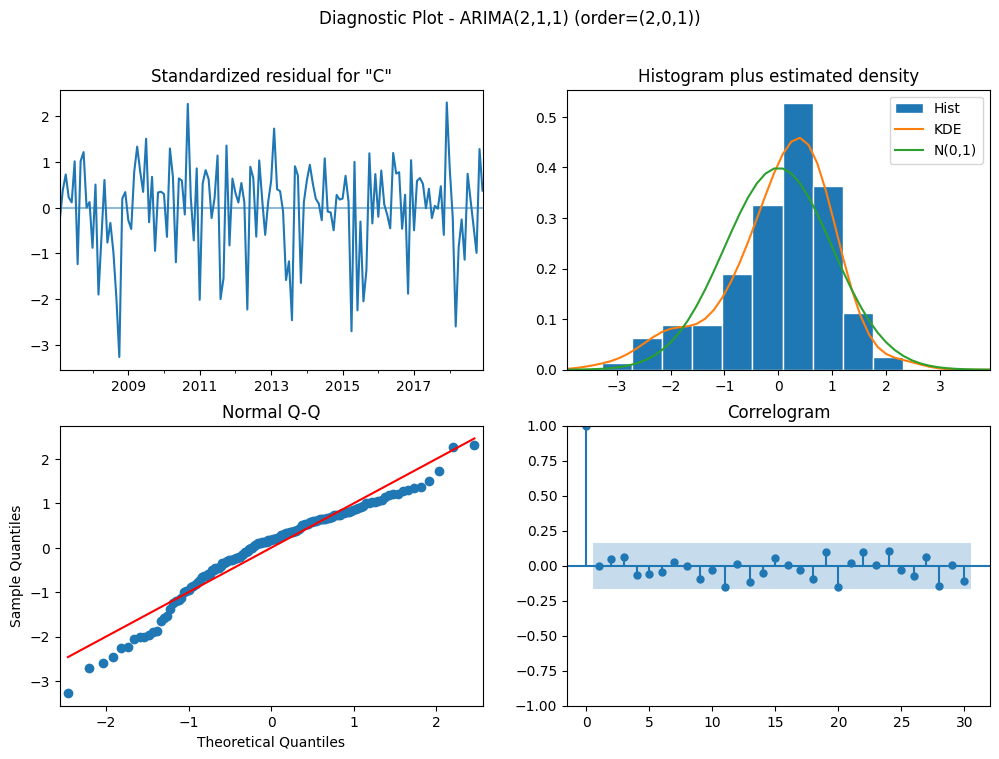

In [49]:
# === 1. PLOT DIAGNOSTIK RESIDUAL ===

# ARIMA(1,1,1)
model_arima1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(1,1,1) (order=(1,0,1))")
plt.show()

# ARIMA(1,1,1) OPEN
model_arima1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(1,1,1)OPEN (order=(1,0,1))")
plt.show()

# ARIMA(2,1,1)
model_arima21.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,1) (order=(2,0,1))")
plt.show()

plt.show()

In [50]:
# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (ARIMA dengan y_train_diff) ===")

# --- ARIMA(1,1,1) ---
print("\n--- Model ARIMA(1,1,1) (order=(1,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima1.resid, nlags=10)[1])
ljungbox_1 = acorr_ljungbox(model_arima1.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_1['lb_stat'].values[0],
      "p-value:", ljungbox_1['lb_pvalue'].values[0])
shapiro_stat_1, shapiro_pval_1 = shapiro(model_arima1.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_1, "p-value:", shapiro_pval_1)
jb_stat_1, jb_pval_1 = jarque_bera(model_arima1.resid)
print("Jarque-Bera - Statistic:", jb_stat_1, "p-value:", jb_pval_1)

# --- ARIMA(1,1,1) OPEN---
print("\n--- Model ARIMA(1,1,1) OPEN (order=(1,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima1open.resid, nlags=10)[1])
ljungbox_1 = acorr_ljungbox(model_arima1open.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_1['lb_stat'].values[0],
      "p-value:", ljungbox_1['lb_pvalue'].values[0])
shapiro_stat_1, shapiro_pval_1 = shapiro(model_arima1open.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_1, "p-value:", shapiro_pval_1)
jb_stat_1, jb_pval_1 = jarque_bera(model_arima1open.resid)
print("Jarque-Bera - Statistic:", jb_stat_1, "p-value:", jb_pval_1)

# --- ARIMA(2,1,1) ---
print("\n--- Model ARIMA(2,1,1) (order=(2,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima21.resid, nlags=10)[1])
ljungbox_2 = acorr_ljungbox(model_arima21.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_2['lb_stat'].values[0],
      "p-value:", ljungbox_2['lb_pvalue'].values[0])
shapiro_stat_2, shapiro_pval_2 = shapiro(model_arima21.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_2, "p-value:", shapiro_pval_2)
jb_stat_2, jb_pval_2 = jarque_bera(model_arima21.resid)
print("Jarque-Bera - Statistic:", jb_stat_2, "p-value:", jb_pval_2)

# --- ARIMA(2,1,1) OPEN---
print("\n--- Model ARIMA(2,1,1) OPEN (order=(2,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima21open.resid, nlags=10)[1])
ljungbox_2 = acorr_ljungbox(model_arima21open.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_2['lb_stat'].values[0],
      "p-value:", ljungbox_2['lb_pvalue'].values[0])
shapiro_stat_2, shapiro_pval_2 = shapiro(model_arima21open.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_2, "p-value:", shapiro_pval_2)
jb_stat_2, jb_pval_2 = jarque_bera(model_arima21open.resid)
print("Jarque-Bera - Statistic:", jb_stat_2, "p-value:", jb_pval_2)


=== UJI STATISTIK RESIDUAL (ARIMA dengan y_train_diff) ===

--- Model ARIMA(1,1,1) (order=(1,0,1)) ---
ARCH Test p-value: 0.760321463969467
Ljung-Box Test - Statistic: 29.285796759990735 p-value: 0.5026228427007308
Shapiro-Wilk - Statistic: 0.9572197607091228 p-value: 0.00020238176876746314
Jarque-Bera - Statistic: 14.791777921709363 p-value: 0.0006137708175260717

--- Model ARIMA(1,1,1) OPEN (order=(1,0,1)) ---
ARCH Test p-value: 0.5615733400883075
Ljung-Box Test - Statistic: 31.233624709881987 p-value: 0.4039875297211269
Shapiro-Wilk - Statistic: 0.9464674590622455 p-value: 2.627459821962875e-05
Jarque-Bera - Statistic: 19.559931347885243 p-value: 5.657373796738005e-05

--- Model ARIMA(2,1,1) (order=(2,0,1)) ---
ARCH Test p-value: 0.7440555754301752
Ljung-Box Test - Statistic: 28.941662498510922 p-value: 0.5206629357732311
Shapiro-Wilk - Statistic: 0.9490475036715399 p-value: 4.2070786531150406e-05
Jarque-Bera - Statistic: 18.882903597954257 p-value: 7.936510269543517e-05

--- Model

1. Autokorelasi (Ljung-Box Test):
* Tidak ada autokorelasi tersisa pada seluruh model (p-value > 0.05)
* Residual acak, menunjukkan bahwa pola data telah ditangkap dengan baik oleh model
2. Heteroskedastisitas (ARCH Test):
* model (ARIMA(1,1,1), (2,1,1), (2,1,0)) menunjukkan tidak ada heteroskedastisitas signifikan (p-value > 0.05)
3. Normalitas (Shapiro-Wilk & Jarque-Bera):
* Seluruh model memiliki residual yang tidak berdistribusi normal

## MODEL TERBAIK ARIMA

In [52]:
import pandas as pd

# Buat DataFrame perbandingan AIC dan BIC
aic_bic_df = pd.DataFrame([
    {'Model': 'ARIMA(0,1,0)', 'AIC': model_rw.aic, 'BIC': model_rw.bic},
    {'Model': 'ARIMA(1,1,0)', 'AIC': model_ar1.aic, 'BIC': model_ar1.bic},
    {'Model': 'ARIMA(0,1,1)', 'AIC': model_ma1.aic, 'BIC': model_ma1.bic},
    {'Model': 'ARIMA(1,1,1)', 'AIC': model_arima1.aic, 'BIC': model_arima1.bic},
    {'Model': 'ARIMA(2,1,1)', 'AIC': model_arima21.aic, 'BIC': model_arima21.bic},
    {'Model': 'ARIMA(0,1,1)OPEN', 'AIC': model_ma1open.aic, 'BIC': model_ma1open.bic},
    {'Model': 'ARIMa(1,1,1)OPEN', 'AIC': model_arima1open.aic, 'BIC': model_arima1open.bic},
    {'Model': 'ARIMA(2,1,1)OPEN', 'AIC': model_arima21open.aic, 'BIC': model_arima21open.bic},
])

# Tampilkan DataFrame
print(aic_bic_df)

              Model          AIC          BIC
0      ARIMA(0,1,0)  1885.958281  1891.883971
1      ARIMA(1,1,0)  1884.907939  1893.796473
2      ARIMA(0,1,1)  1884.881833  1893.770367
3      ARIMA(1,1,1)  1886.897869  1898.749247
4      ARIMA(2,1,1)  1887.612410  1902.426633
5  ARIMA(0,1,1)OPEN  1873.915845  1882.804379
6  ARIMa(1,1,1)OPEN  1872.629511  1884.480890
7  ARIMA(2,1,1)OPEN  1874.475458  1889.289682


	Model ARIMA(0,1,1) Data close dan ARIMA (1,1,1) open adalah model terbaik secara keseluruhan, berdasarkan:
	* Nilai AIC dan BIC terendah
	* Parameter signifikan
	* Hasil diagnostik residual yang baik

# PREDIKSI DENGAN MODEL TERBAIK

## FORECASTING DATA TESTING CLOSE

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# === Forecasting Data Testing dengan ARIMAX(0,1,1) ===
forecast = model_ma1.get_forecast(steps=len(y_test))
predicted_diff = forecast.predicted_mean

# Invers differencing: hasil = nilai terakhir training + kumulatif prediksi selisih
predicted = y_train.iloc[-1] + predicted_diff.cumsum()

# Buat DataFrame hasil prediksi
hasil_forecast = y_test.copy()
hasil_forecast = hasil_forecast.to_frame(name='Aktual')
hasil_forecast['Prediksi'] = predicted.values

# Tampilkan hasil prediksi
print("=== Hasil Prediksi ARIMA(0,1,1) pada Data Testing ===")
print(hasil_forecast)

=== Hasil Prediksi ARIMA(0,1,1) pada Data Testing ===
             Aktual     Prediksi
Date                            
2019-01-31  6532.97  6236.681770
2019-02-28  6443.35  6267.720075
2019-03-31  6468.75  6298.758381
2019-04-30  6455.35  6329.796686
2019-05-31  6209.12  6360.834992
2019-06-30  6358.63  6391.873297
2019-07-31  6390.50  6422.911603
2019-08-31  6328.47  6453.949908
2019-09-30  6169.10  6484.988214
2019-10-31  6228.32  6516.026519
2019-11-30  6011.83  6547.064825
2019-12-31  6299.54  6578.103130
2020-01-31  5940.05  6609.141436
2020-02-28  5452.70  6640.179741
2020-03-31  4538.93  6671.218047
2020-04-30  4716.40  6702.256352
2020-05-31  4753.61  6733.294658
2020-06-30  4905.39  6764.332963
2020-07-31  5149.63  6795.371269
2020-08-31  5238.49  6826.409574
2020-09-30  4870.04  6857.447880
2020-10-31  5128.23  6888.486185
2020-11-30  5612.42  6919.524491
2020-12-31  5979.07  6950.562796


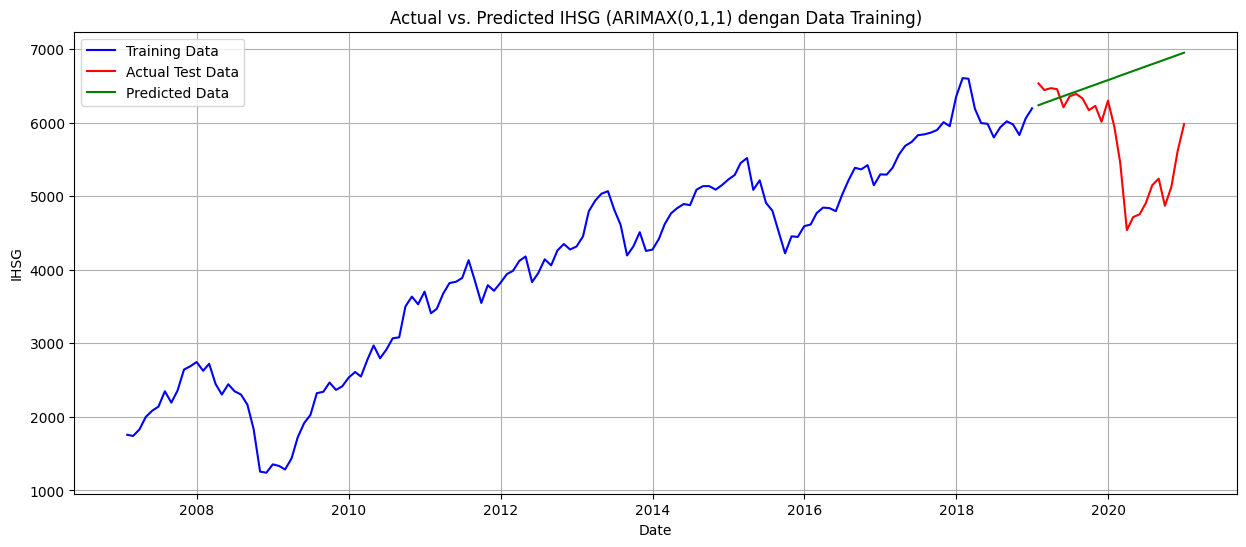

In [55]:
# === Plot data aktual vs. prediksi ===
plt.figure(figsize=(15, 6))

# Plot data training
plt.plot(train.index, y_train, label='Training Data', color='blue')

# Plot data testing aktual
plt.plot(test.index, y_test, label='Actual Test Data', color='red')

# Plot hasil prediksi ARIMAX (sudah transformasi balik)
plt.plot(y_test.index, predicted, label='Predicted Data', color='green')

plt.xlabel('Date')
plt.ylabel('IHSG')
plt.title('Actual vs. Predicted IHSG (ARIMAX(0,1,1) dengan Data Training)')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# === Evaluasi Model ===
# Invers transformasi (Jika perlu) atau gunakan nilai asli prediksi
mape_test = mean_absolute_percentage_error(y_test, predicted)
mae_test = mean_absolute_error(y_test, predicted)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted))

print("=== Evaluasi Model ARIMAX(0,1,1) pada Data Testing ===")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


=== Evaluasi Model ARIMAX(0,1,1) pada Data Testing ===
MAPE: 0.1746
MAE : 900.0405
RMSE: 1179.7652


Model ARIMA(0,1,1) menghasilkan prediksi nilai IHSG dengan nilai MAPE sebesar 17.46%, yang tergolong dalam kategori akurasi sedang. Nilai kesalahan prediksi ini dapat dipengaruhi oleh pandemi COVID-19 pada tahun 2020, yang menyebabkan penurunan drastis pada IHSG. Dampak dari peristiwa ini membuat nilai aktual IHSG menyimpang cukup jauh dari pola historis, sehingga model ARIMA tidak mampu menangkap dinamika mendadak tersebut, yang akhirnya meningkatkan tingkat kesalahan prediksi.

## FORECASTING DATA TESTING OPEN

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# === Forecasting Data Testing dengan ARIMAX(1,1,0) ===
forecast = model_arima1open.get_forecast(steps=len(y_test_open))
predicted_diff = forecast.predicted_mean

# Invers differencing: hasil = nilai terakhir training + kumulatif prediksi selisih
predicted = y_train_open.iloc[-1] + predicted_diff.cumsum()

# Buat DataFrame hasil prediksi
hasil_forecast = y_test_open.copy()
hasil_forecast = hasil_forecast.to_frame(name='Aktual')
hasil_forecast['Prediksi'] = predicted.values

# Tampilkan hasil prediksi
print("=== Hasil Prediksi ARIMA(1,1,1) OPEN pada Data Testing ===")
print(hasil_forecast)

=== Hasil Prediksi ARIMA(1,1,1) OPEN pada Data Testing ===
             Aktual     Prediksi
Date                            
2019-01-31  6197.87  6214.104339
2019-02-28  6552.06  6208.230797
2019-03-31  6468.62  6258.235884
2019-04-30  6485.72  6277.604333
2019-05-31  6458.12  6313.769966
2019-06-30  6277.29  6340.726188
2019-07-31  6381.18  6372.731664
2019-08-31  6385.26  6401.968780
2019-09-30  6331.15  6432.723708
2019-10-31  6163.98  6462.646463
2019-11-30  6225.81  6493.025475
2019-12-31  6023.61  6523.154334
2020-01-31  6313.13  6553.420345
2020-02-28  5920.97  6583.611159
2020-03-31  5455.05  6613.843202
2020-04-30  4538.93  6644.052640
2020-05-31  4716.40  6674.274472
2020-06-30  4753.61  6704.489508
2020-07-31  4905.39  6734.708270
2020-08-31  5149.63  6764.924990
2020-09-30  5238.49  6795.142829
2020-10-31  4899.64  6825.360055
2020-11-30  5108.03  6855.577617
2020-12-31  5637.89  6885.794994


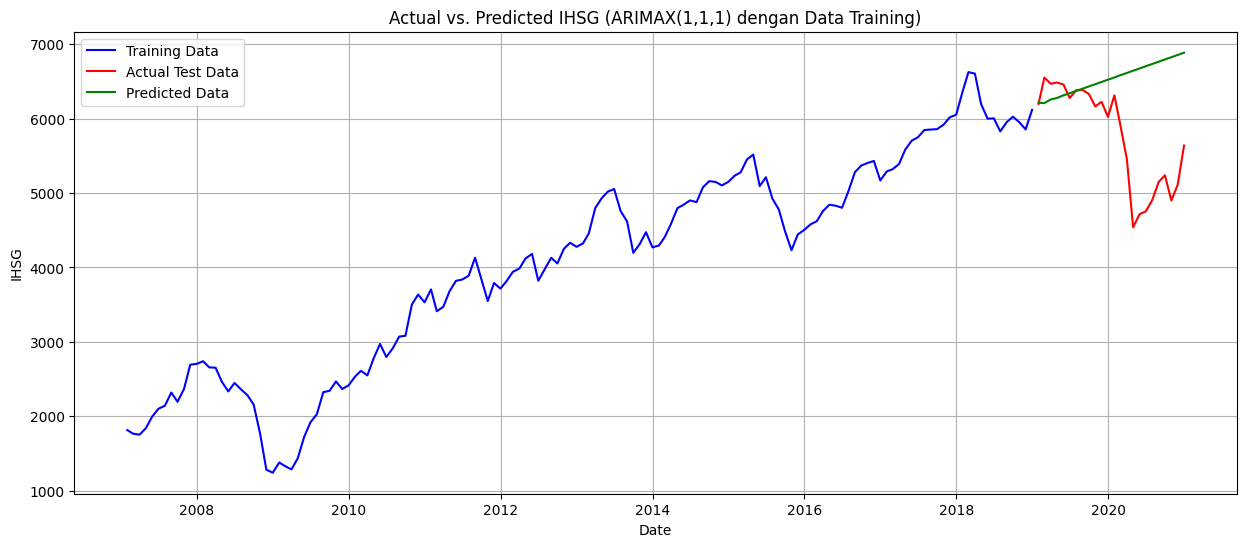

In [59]:
# === Plot data aktual vs. prediksi ===
plt.figure(figsize=(15, 6))

# Plot data training
plt.plot(train.index, y_train_open, label='Training Data', color='blue')

# Plot data testing aktual
plt.plot(test.index, y_test_open, label='Actual Test Data', color='red')

# Plot hasil prediksi ARIMAX (sudah transformasi balik)
plt.plot(y_test_open.index, predicted, label='Predicted Data', color='green')

plt.xlabel('Date')
plt.ylabel('IHSG')
plt.title('Actual vs. Predicted IHSG (ARIMAX(1,1,1) dengan Data Training)')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# === Evaluasi Model ===
# Invers transformasi (Jika perlu) atau gunakan nilai asli prediksi
mape_test = mean_absolute_percentage_error(y_test_open, predicted)
print("=== Evaluasi Model ARIMAX(1,1,1) pada Data Testing OPEN ===")
print(f"MAPE: {mape_test:.4f}")


=== Evaluasi Model ARIMAX(1,1,1) pada Data Testing OPEN ===
MAPE: 0.1641


Model ARIMA(0,1,1) menghasilkan prediksi nilai IHSG dengan nilai MAPE sebesar 16.41%, yang tergolong dalam kategori akurasi sedang.

# PERAMALAN 1 TAHUN KEDEPAN

## CLOSE

=== Hasil Peramalan IHSG 24 Bulan ke Depan (ARIMA(0,1,1)) ===
              Peramalan
2021-01-01  6236.681770
2021-02-01  6267.720075
2021-03-01  6298.758381
2021-04-01  6329.796686
2021-05-01  6360.834992
2021-06-01  6391.873297
2021-07-01  6422.911603
2021-08-01  6453.949908
2021-09-01  6484.988214
2021-10-01  6516.026519
2021-11-01  6547.064825
2021-12-01  6578.103130
2022-01-01  6609.141436
2022-02-01  6640.179741
2022-03-01  6671.218047
2022-04-01  6702.256352
2022-05-01  6733.294658
2022-06-01  6764.332963
2022-07-01  6795.371269
2022-08-01  6826.409574
2022-09-01  6857.447880
2022-10-01  6888.486185
2022-11-01  6919.524491
2022-12-01  6950.562796


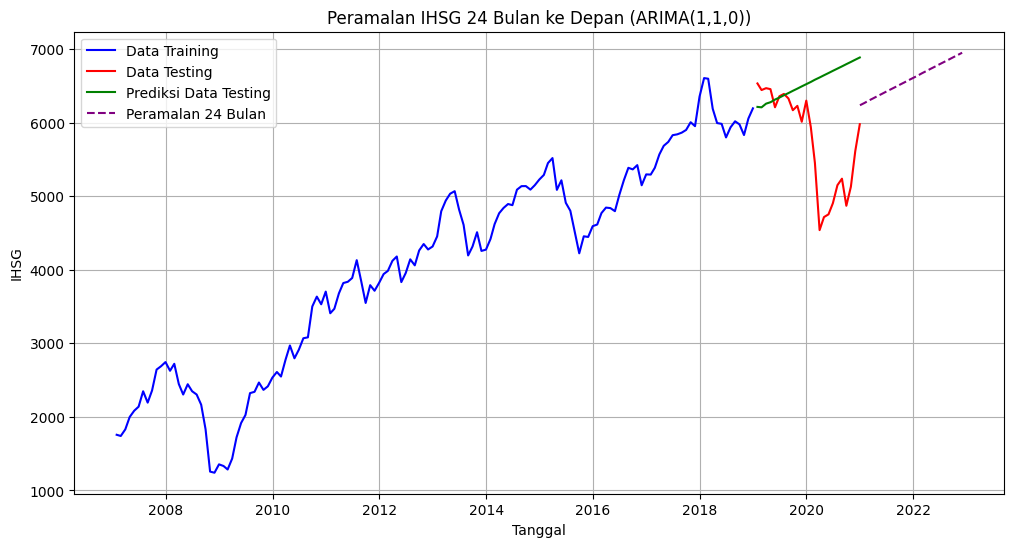

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Menentukan periode peramalan (24 bulan ke depan, mulai Januari 2025)
future_dates = pd.date_range(start='2021-01-01', periods=24, freq='MS')

# Melakukan peramalan menggunakan model ARIMA(1,1,0)
forecast = model_ma1.get_forecast(steps=24)
predicted_diff_future = forecast.predicted_mean

# Invers differencing untuk mendapatkan nilai IHSG
predicted_future = y_train.iloc[-1] + predicted_diff_future.cumsum()

# Membuat DataFrame hasil peramalan
hasil_peramalan = pd.DataFrame(index=future_dates, columns=['Peramalan'])
hasil_peramalan['Peramalan'] = predicted_future.values

# Menampilkan hasil peramalan
print("=== Hasil Peramalan IHSG 24 Bulan ke Depan (ARIMA(0,1,1)) ===")
print(hasil_peramalan)

# Plot data
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(y_train.index, y_train, label='Data Training', color='blue')

# Plot data testing aktual
plt.plot(y_test.index, y_test, label='Data Testing', color='red')

# Plot hasil prediksi ARIMA (sudah transformasi balik)
plt.plot(y_test.index, predicted, label='Prediksi Data Testing', color='green')

# Plot peramalan 24 bulan ke depan
plt.plot(hasil_peramalan.index, hasil_peramalan['Peramalan'], label='Peramalan 24 Bulan', color='purple', linestyle='--')

# Menambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('IHSG')
plt.title('Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0))')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

##OPEN

=== Hasil Peramalan IHSG Open 24 Bulan ke Depan (ARIMA(1,1,1)) ===
              Peramalan
2021-01-01  6214.104339
2021-02-01  6208.230797
2021-03-01  6258.235884
2021-04-01  6277.604333
2021-05-01  6313.769966
2021-06-01  6340.726188
2021-07-01  6372.731664
2021-08-01  6401.968780
2021-09-01  6432.723708
2021-10-01  6462.646463
2021-11-01  6493.025475
2021-12-01  6523.154334
2022-01-01  6553.420345
2022-02-01  6583.611159
2022-03-01  6613.843202
2022-04-01  6644.052640
2022-05-01  6674.274472
2022-06-01  6704.489508
2022-07-01  6734.708270
2022-08-01  6764.924990
2022-09-01  6795.142829
2022-10-01  6825.360055
2022-11-01  6855.577617
2022-12-01  6885.794994


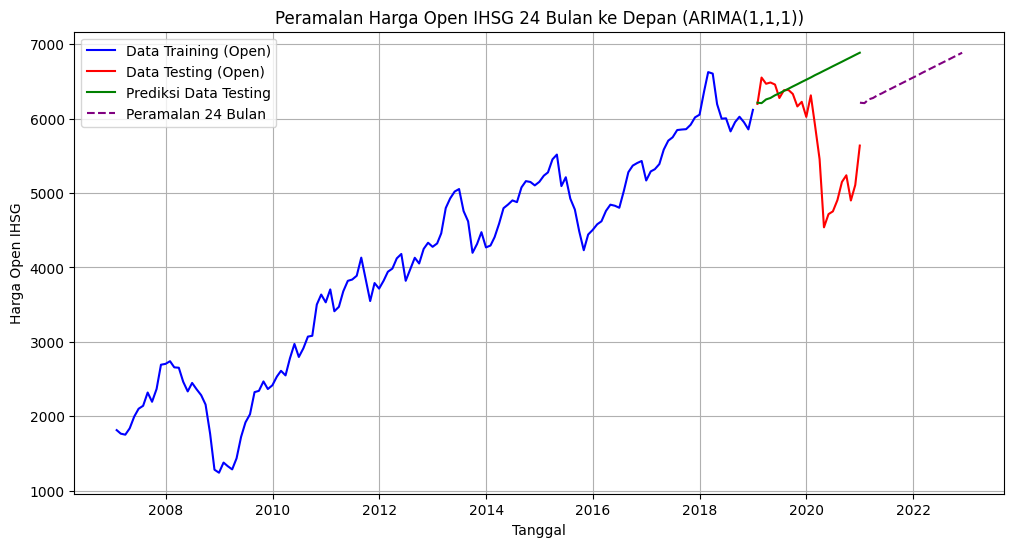

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Menentukan periode peramalan (24 bulan ke depan, mulai Januari 2025)
future_dates = pd.date_range(start='2021-01-01', periods=24, freq='MS')

# Melakukan peramalan menggunakan model AR(1) untuk data Open
forecast = model_arima1open.get_forecast(steps=24)
predicted_diff_future = forecast.predicted_mean

# Invers differencing untuk mendapatkan nilai prediksi aktual
predicted_future = y_train_open.iloc[-1] + predicted_diff_future.cumsum()

# Membuat DataFrame hasil peramalan
hasil_peramalan = pd.DataFrame(index=future_dates, columns=['Peramalan'])
hasil_peramalan['Peramalan'] = predicted_future.values

# Menampilkan hasil peramalan
print("=== Hasil Peramalan IHSG Open 24 Bulan ke Depan (ARIMA(1,1,1)) ===")
print(hasil_peramalan)

# Plot data
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(y_train_open.index, y_train_open, label='Data Training (Open)', color='blue')

# Plot data testing aktual
plt.plot(y_test_open.index, y_test_open, label='Data Testing (Open)', color='red')

# Plot hasil prediksi (menggunakan nama 'predicted' seperti sebelumnya)
plt.plot(y_test_open.index, predicted, label='Prediksi Data Testing', color='green')

# Plot peramalan 24 bulan ke depan
plt.plot(hasil_peramalan.index, hasil_peramalan['Peramalan'], label='Peramalan 24 Bulan', color='purple', linestyle='--')

# Tambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('Harga Open IHSG')
plt.title('Peramalan Harga Open IHSG 24 Bulan ke Depan (ARIMA(1,1,1))')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()